In [1]:
import os
import pandas as pd
import netCDF4 as nc
from pathlib import Path
# from natsort import natsorted
import matplotlib.pyplot as plt
import gc
from os.path import exists
import dask_labextension
import numpy as np
import gsw
import cmocean.cm as cm
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm

In [2]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.0.1 
xwmt version 0.1.1 
xwmb version 0.1.1


In [3]:
import matplotlib.pyplot as plt

def hovmoller(wmt, var, robust=False, units="kg", **kwargs):
    da = wmt[var]
    if robust:
        vmax = np.abs(da).quantile(0.95).compute()
        kwargs["vmin"] = -vmax
        kwargs["vmax"] = vmax

    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    time_idx_bounds = xr.DataArray(np.arange(0, wmt.time_bounds.size), dims=('time_bounds',))
    pc = plt.pcolor(
        time_idx_bounds,
        coord_bounds,
        da.transpose() if da.dims[0] == "time" else da,
        **kwargs
    )

    dtick = da.time.size//12
    date_str = [f"{d.year}-{str(d.month).zfill(2)}-{str(d.day).zfill(2)}" for d in wmt["time_bounds"].values[::dtick]]
    plt.xticks(time_idx_bounds[::dtick], date_str, rotation=90)
    plt.colorbar(label=f"transformation rate [{units}]")
    for coord_bound in coord_bounds:
        plt.axhline(coord_bound, color="k", lw=0.25)
    
    return pc

def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

### Request HPC Resources

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=2)
from dask.distributed import Client
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.125:35092 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.125:35092,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("CM4Xp25_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"exp":1},
        engine="zarr")

ds["areacello"] = (ds["areacello"]* ds["wet"])  / (ds["areacello"] * ds["wet"]).sum() #areacello should be the fraction of ocean area at each grid cell, not the actual area

### Add density layer midpoints

In [6]:
sigma2_i = (ds.sigma2_l.values[1:] + ds.sigma2_l.values[0:-1])/2
ds = ds.assign_coords({"sigma2_i":np.concatenate(([-100.], sigma2_i, [100.]))})
ds = ds.fillna(0.) #remove all NaNs

### Create xgcm grid object

In [7]:
#create an xgcm grid from data 
Zprefix = "sigma2_"

coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'},
}

metrics = {
    ('X','Y'): "areacello",
}

boundary = {"X":"extend", "Y":"extend", "Z":"extend"}

grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata=False)

# We specify our target density bins based on the online density-coordinate diagnostics
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)

### Collect budget terms

In [8]:
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid, budgets_dict)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


### Plot Baltic mask

/tmp/ipykernel_156804/2825249763.py:17: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pc, label="depth [m]")


Text(0.5, 1.0, 'OSNAP-East')

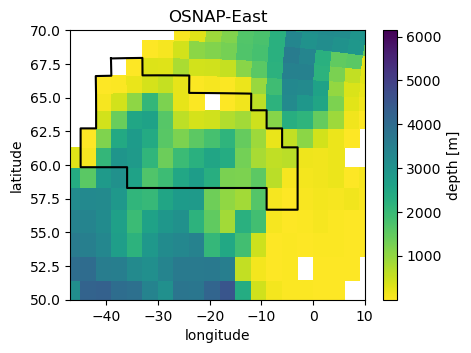

In [21]:
# Note: the properties of this region are quite different from the rest of the Baltic!
# OSNAP-EAST
name = "Labrador"
lons = np.array([-56.8775, -52.0956, -49.8604, -47.6107, -44.8000, -50,  -56.0, -61.5,  -63.5, -63.5])
lats = np.array([52.0166,   52.6648,  53.5577,  58.8944,  60.4000,  66.5, 66.5,  66.0,   66.0,  57.5])
region = regionate.GriddedRegion(name, lons, lats, grid)

depth = grid._ds['deptho']
depth = depth.where(depth >0)
plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    depth,
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(-47, 10)
plt.ylim(50, 70)
plt.title("OSNAP-East")

### Extract mass budget

In [33]:
import warnings
kwargs = {"greater_than":True, "default_bins":False}

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    lam = "sigma2"
    wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict,
            region
        )
    wmb.mass_budget(lam, integrate=True, along_section=False, **kwargs)
    wmb.wmt.load()
    wmt = wmb.wmt


### Hovmoller Diagram

In [34]:
toSv = 1.e-6/wmb.rho_ref
wmt1 = wmt.isel(exp = 1).compute()*toSv #select the historical run

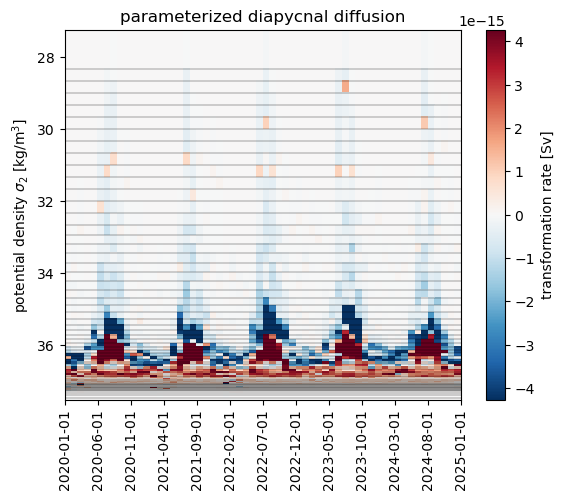

In [35]:
pc = hovmoller(wmt1, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

### Time-mean budget

In [36]:
wmt_mean = wmt.isel(exp = 1).mean('time').compute()*toSv

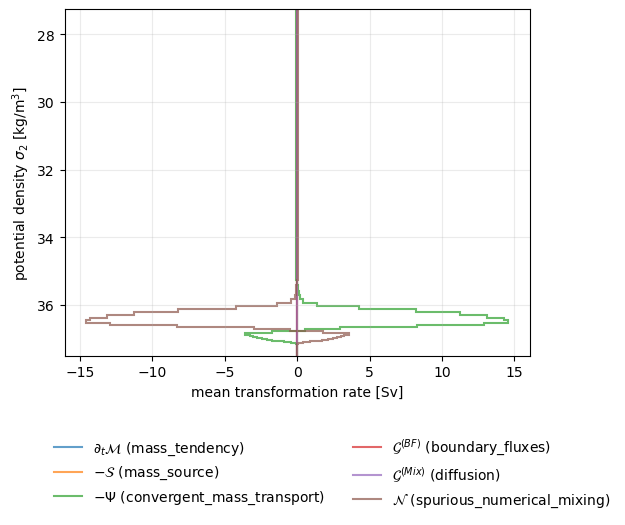

In [37]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$ (mass_tendency)",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$ (mass_source)",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\Psi$ (convergent_mass_transport)",                   **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$ (boundary_fluxes)",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$ (diffusion)",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{N}$ (spurious_numerical_mixing)", **kwargs)

plt.legend(loc="upper right", frameon = False, ncols = 2, bbox_to_anchor = (1.2, -0.2))
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim( 37.5, 27.25,);

In [38]:
x = 4